In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_4^{(0.5)}$

In [7]:
reco='recoJet_tau_0p5_3_nom_dijetSel'
gen='genJet_tau_0p5_3_dijetSel'
response='respJet_tau_0p5_3_nom_dijetSel'

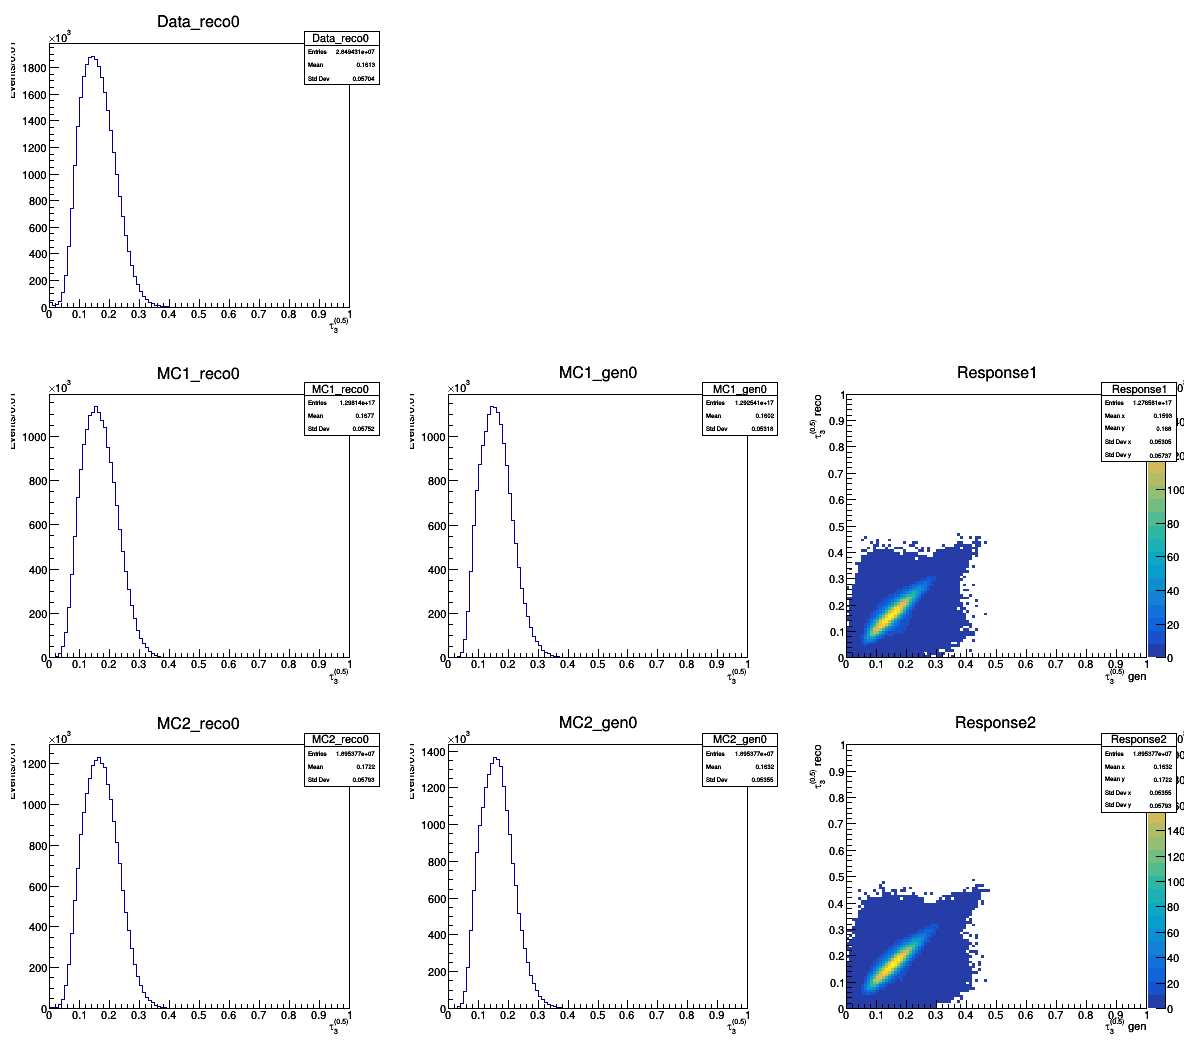

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(0.5)} gen;#tau_{3}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(0.5)} gen;#tau_{3}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 1298.55695095 2968.21237253
0.015 720.357205098 3255.52691355
0.025 2196.50524837 6554.90097677
0.035 8528.85494884 18949.3129728
0.045 28235.7967718 45917.8107044
0.055 92793.8642699 110858.453208
0.065 222285.648062 215085.405638
0.075 425034.573273 365909.897383
0.085 642776.337333 530080.490979
0.095 847020.531375 688498.4386
0.105 994398.525523 853092.224826
0.115 1093437.45243 963416.959255
0.125 1203338.50751 1053821.61537
0.135 1274257.60827 1130438.49714
0.145 1332637.47196 1193319.90879
0.155 1366210.79564 1214722.28024
0.165 1353774.46938 1232318.21326
0.175 1314934.056 1200411.3836
0.185 1209986.92267 1183440.50349
0.195 1078161.45441 1100033.12388
0.205 944632.975896 1024385.5548
0.215 790250.106997 917363.620788
0.225 667763.739817 816937.941065
0.235 519399.524315 712260.114808
0.245 427076.515467 577416.348007
0.255 325291.259689 469636.709317
0.265 248142.147681 384232.266915
0.275 178918.515481 293194.062569
0.285 135678.492288 216502.677227
0.295 96440.2321929 

# Different bins

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.49])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.39,0.49])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.32)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.49])))
reco_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.32)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.4,0.49])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.49])))
reco_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.42,0.49])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=10,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.49])))
reco_bins1=np.array([x for x in np.linspace(num=19,start=0,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.42,0.49])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=19,start=0.,stop=0.36)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.49])))
reco_bins1=np.array([x for x in np.linspace(num=37,start=0.,stop=0.36)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.42,0.49])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.3  0.49] 4
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.39 0.49] 8
[0.   0.08 0.16 0.24 0.32 0.49] 5
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.4  0.49] 10
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.49] 7
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.42
 0.49] 14
0.0,0.06,0.12,0.18,0.24,0.3,0.36,0.49
0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.32999999999999996,0.36,0.42,0.49
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.49] 10
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.42 0.49] 20
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.49] 19
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.42 0.49] 38


In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{3}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{3}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{3}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{3}^{(0.5)} gen;#tau_{3}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{3}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{3}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.3  0.49]
for binning 2
[0.   0.08 0.16 0.24 0.32 0.49]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.49]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.49]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.49]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{3}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{3}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <

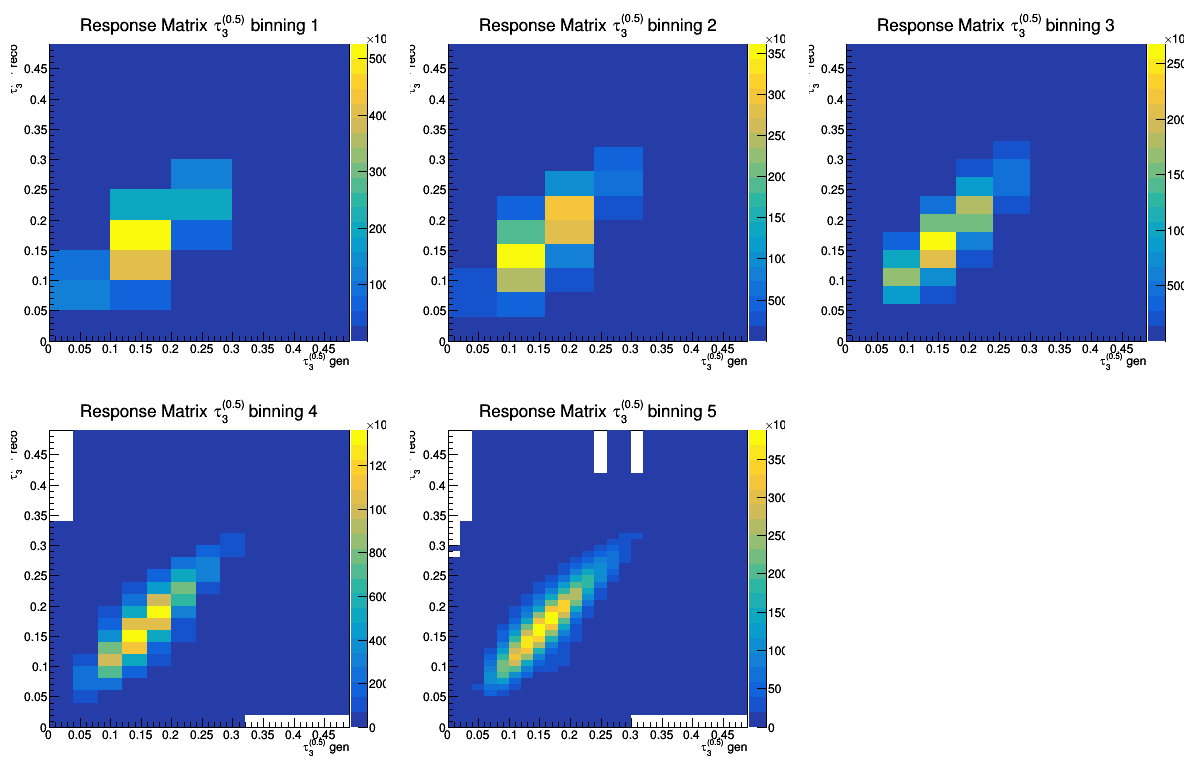

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


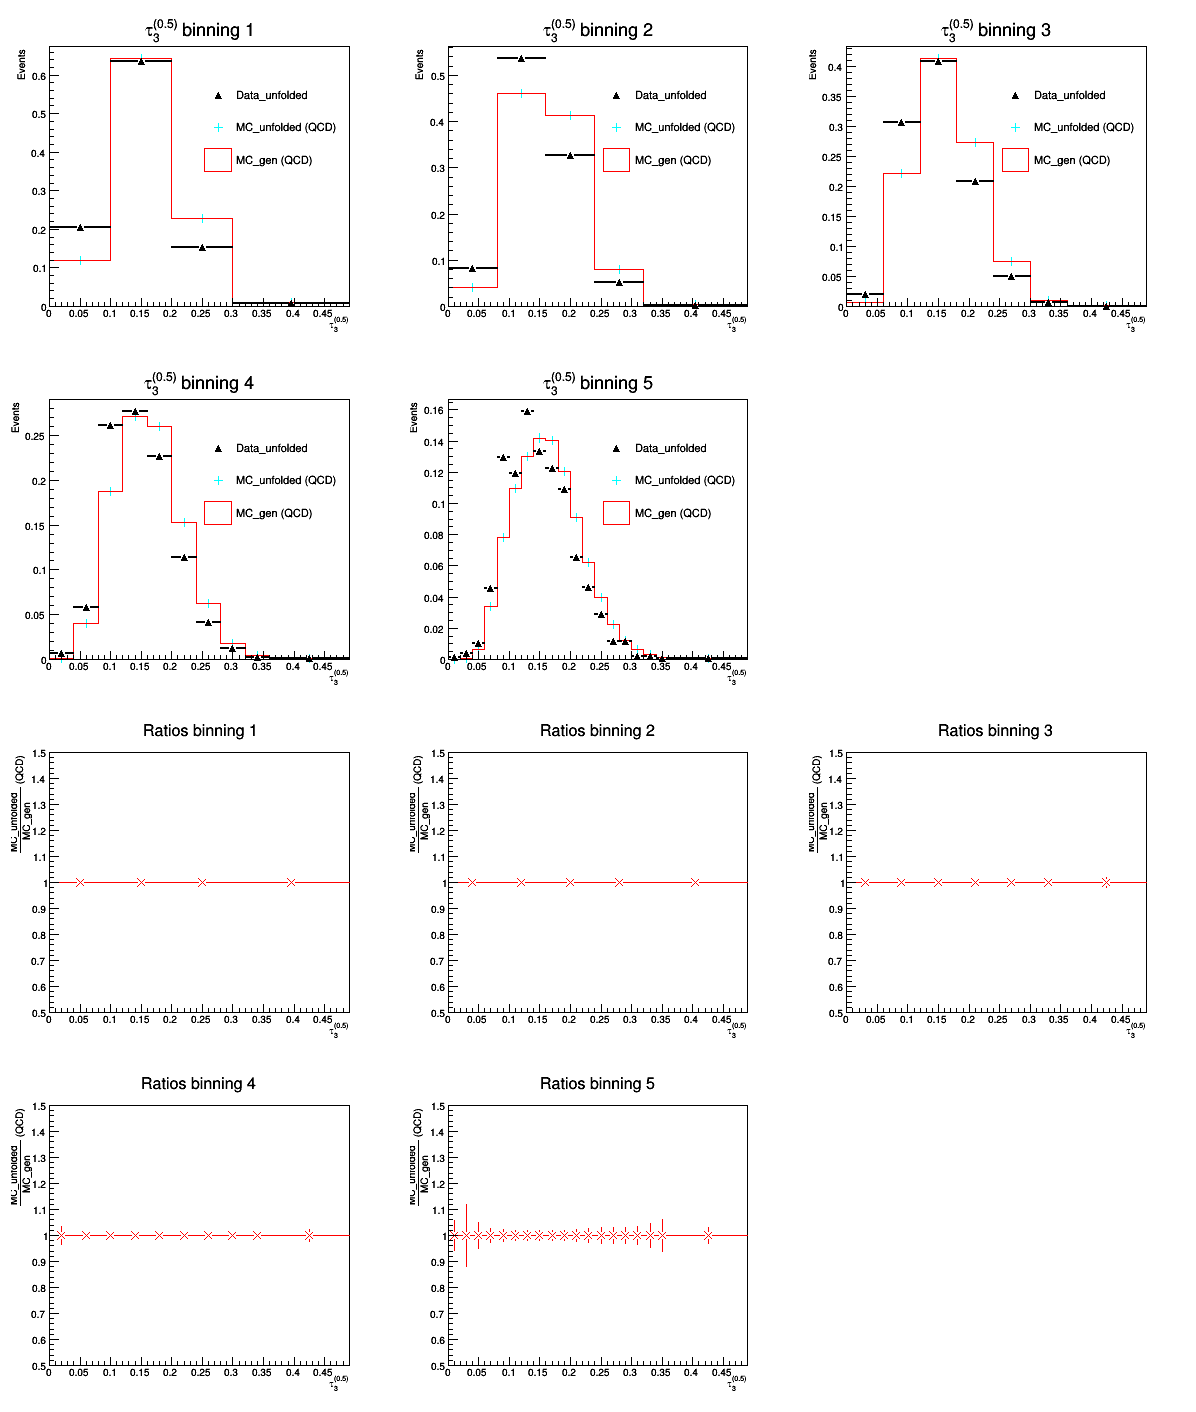

In [13]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{3}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

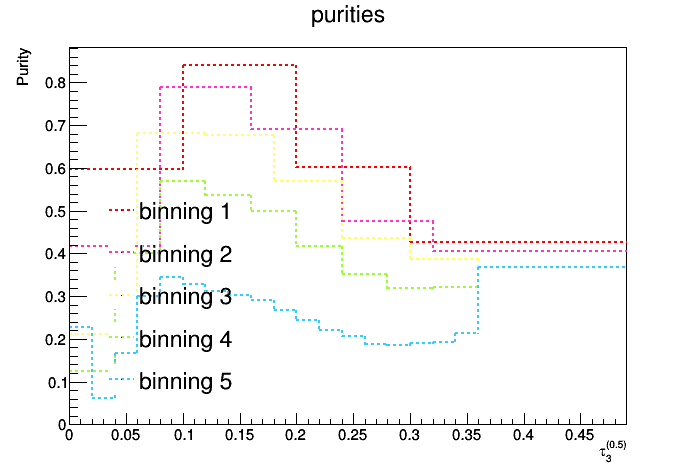

In [14]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

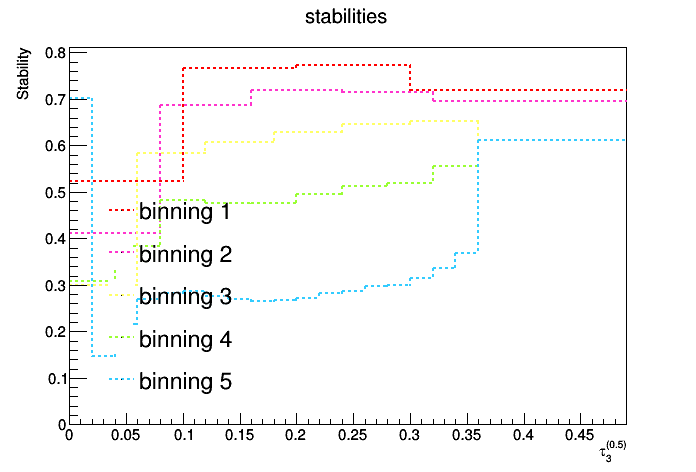

In [15]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response_tau_0p5_3_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_0p5_3_dijetSel.png has been created


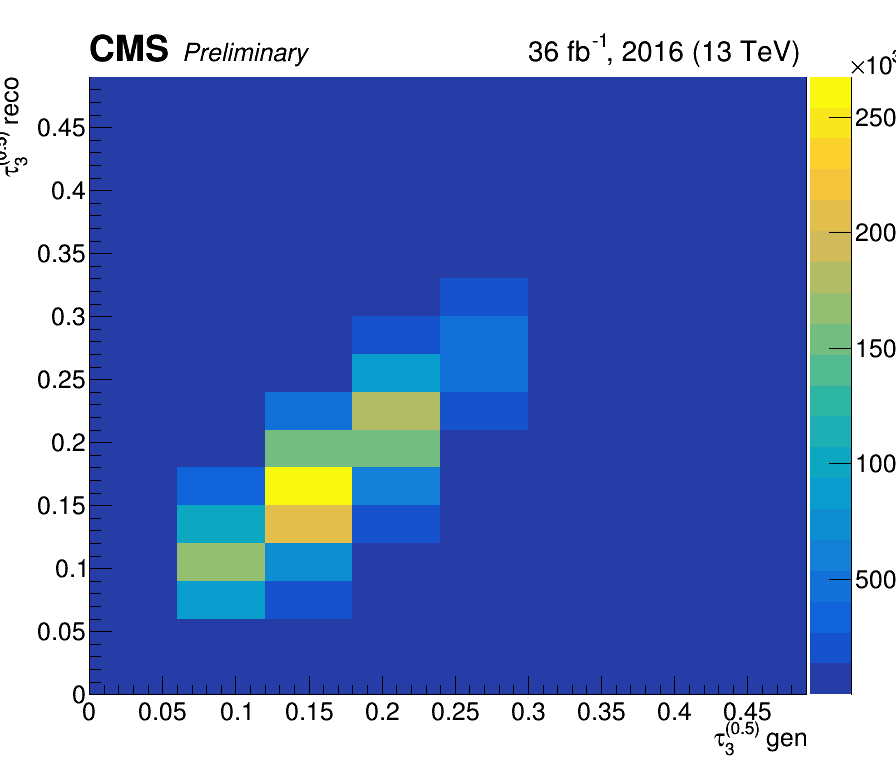

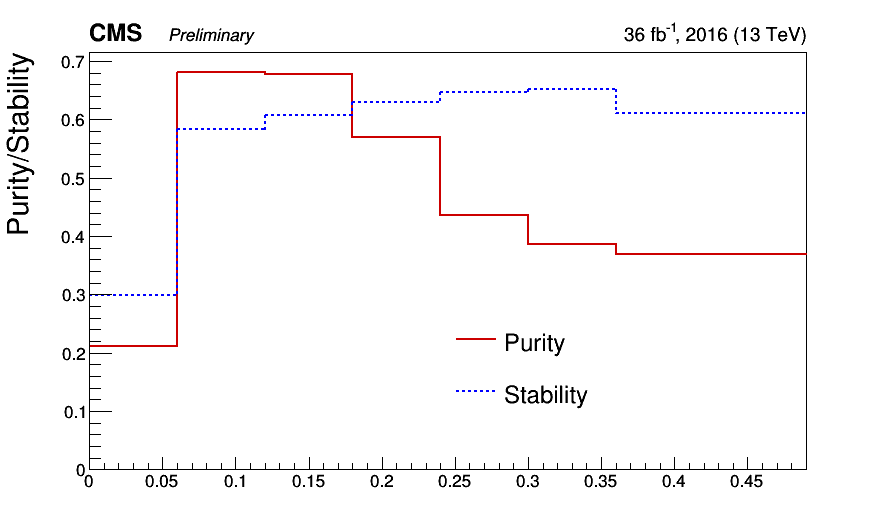

In [18]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV="36 fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.2,0.75,0.4)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_{4}^{(1)}$

In [7]:
reco='recoJet_tau_1_3_nom_dijetSel'
gen='genJet_tau_1_3_dijetSel'
response='respJet_tau_1_3_nom_dijetSel'

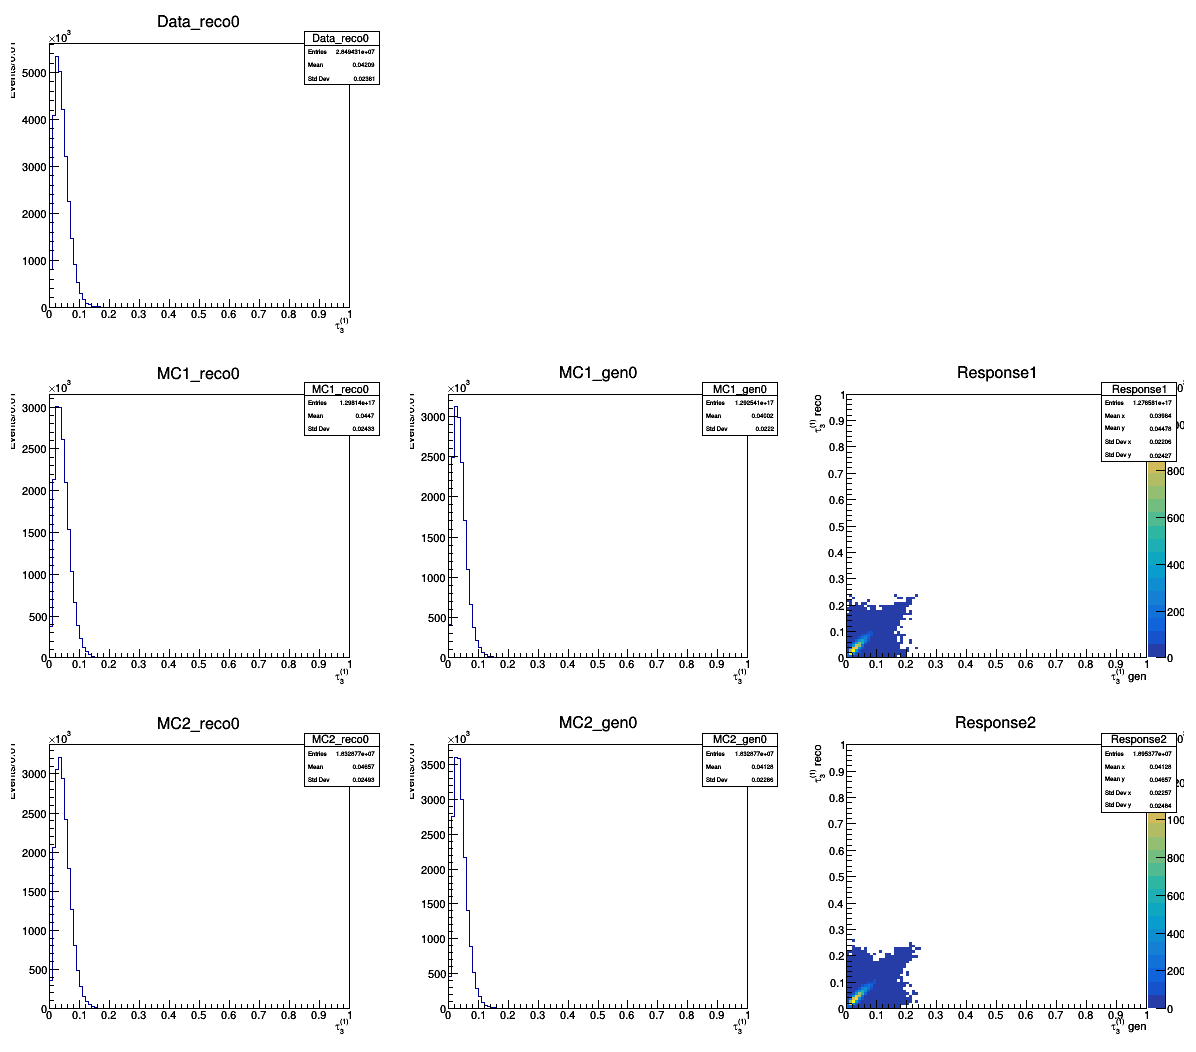

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 457398.064593 362199.172128
0.015 2752245.82971 2061115.47001
0.025 3601842.53312 3062968.87688
0.035 3586021.87093 3212475.50515
0.045 3003389.48274 2941030.24481
0.055 2165603.85405 2420419.91723
0.065 1411624.12367 1793726.10459
0.075 882427.897811 1261136.10651
0.085 519006.832394 807039.805708
0.095 288898.318165 492452.461205
0.105 165843.62298 276475.475042
0.115 91900.7122414 157051.127427
0.125 49239.1359121 86232.5607607
0.135 32077.5626356 51277.5594695
0.145 13840.3101381 24894.6412477
0.155 7986.48862185 13970.9364176
0.165 4331.22724902 6034.15800033
0.175 1377.78701732 3747.68585931
0.185 898.995724176 1328.08139232
0.195 460.513919773 606.638060342
0.205 275.006797417 253.537153238
0.215 29.8301710639 124.775603371
0.225 79.7905110408 168.218810702
0.235 6.98411980566 77.3089441624
0.245 2.64497946061 0.13412654632
0.255 0.0 2.917646271
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.3

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.12)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.26])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.12)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.19,0.26])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.12)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.26])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.12)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.19,0.26])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.06)])
temp=np.array([x for x in np.linspace(num=3,start=0.1,stop=0.18)])
gen_bins1=np.concatenate((gen_bins1,temp,np.array([0.26])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.06)])
temp=np.array([x for x in np.linspace(num=5,start=0.1,stop=0.18)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.08]),temp,np.array([0.19,0.26])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.06 0.12 0.26] 3
[0.   0.03 0.06 0.09 0.12 0.19 0.26] 6
[0.   0.04 0.08 0.12 0.26] 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.19 0.26] 8
[0.   0.02 0.04 0.06 0.1  0.14 0.18 0.26] 7
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.19
 0.26] 14
0.0,0.02,0.04,0.06,0.1,0.14,0.18,0.26
0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.19,0.26


In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{3}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{3}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{3}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{3}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{3}^{(1)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(1)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.06 0.12 0.26]
for binning 2
[0.   0.04 0.08 0.12 0.26]
for binning 3
[0.   0.02 0.04 0.06 0.1  0.14 0.18 0.26]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{3}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 6 input bins and 3 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #4 (xaxis:#tau_{3}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <TROOT::A

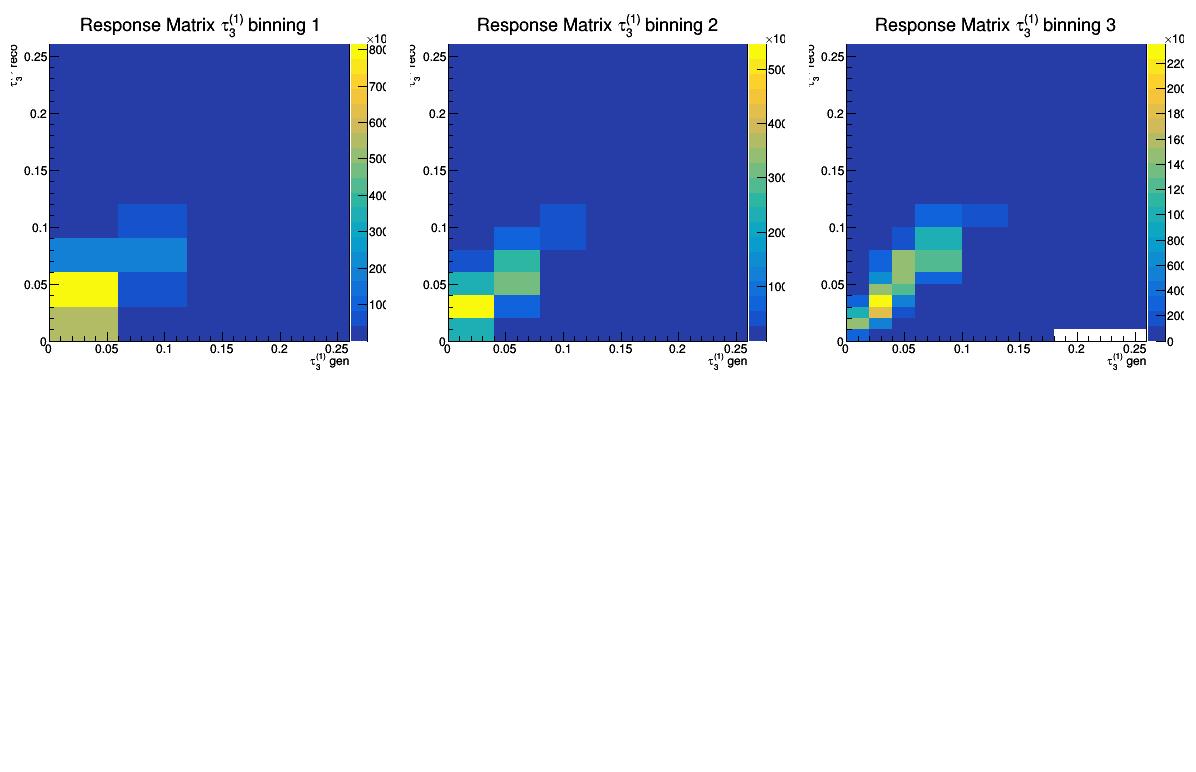

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


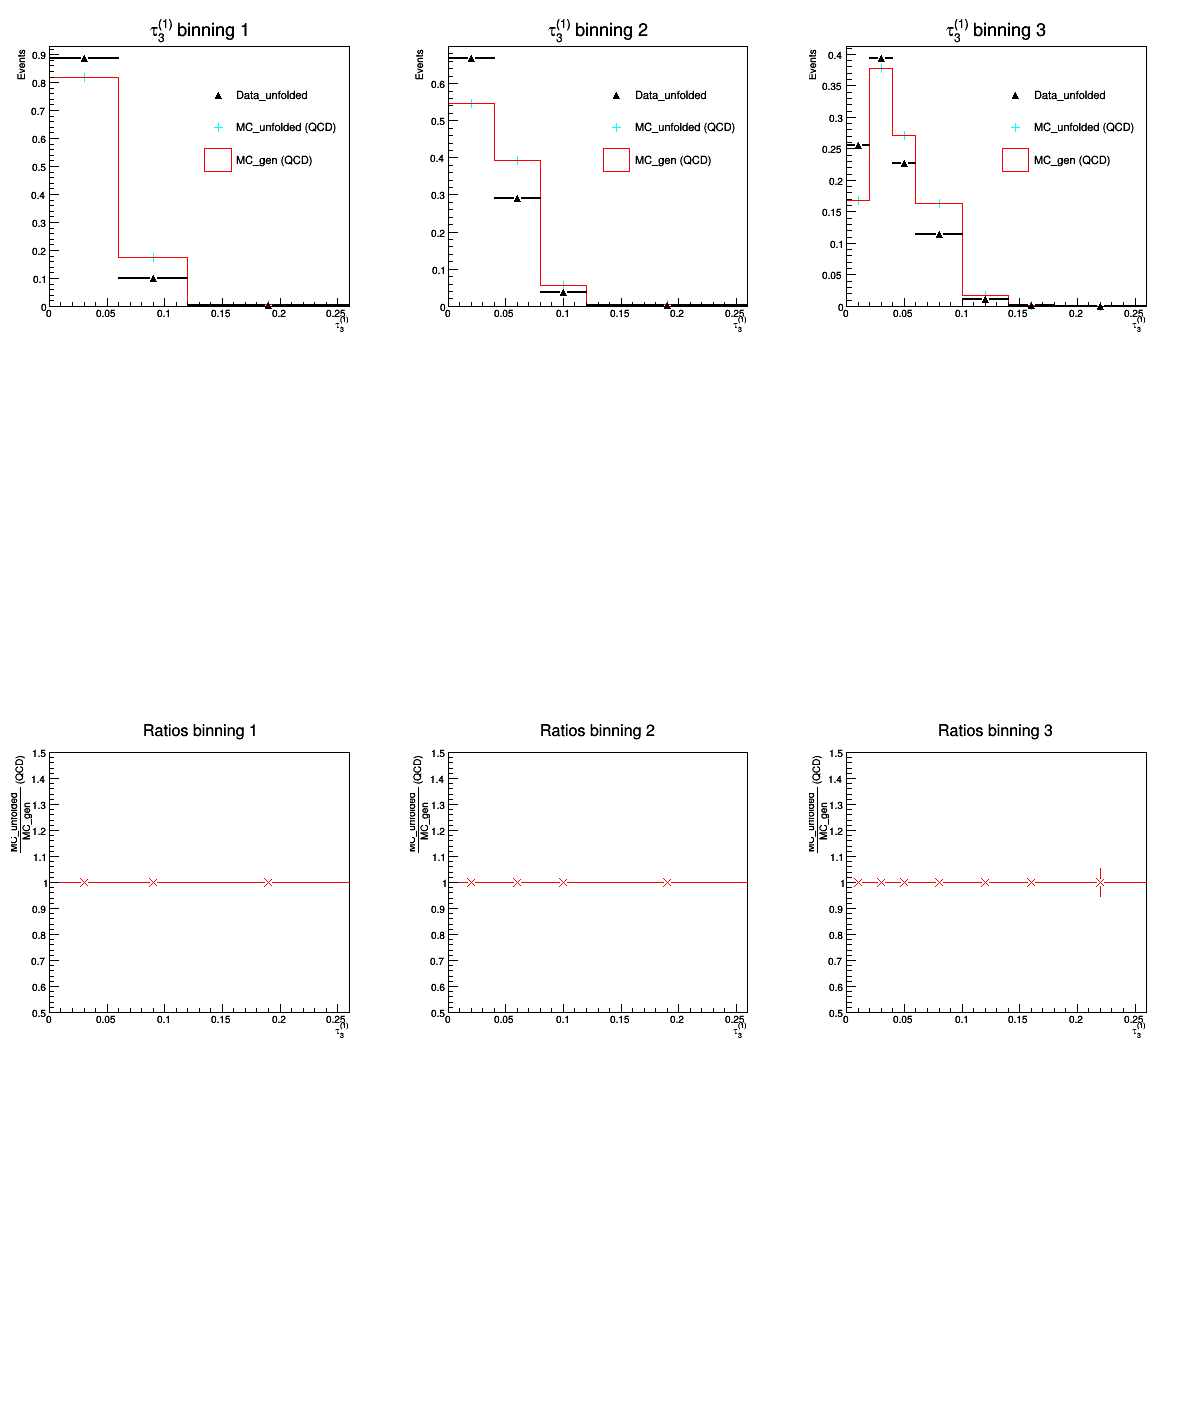

In [13]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{3}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

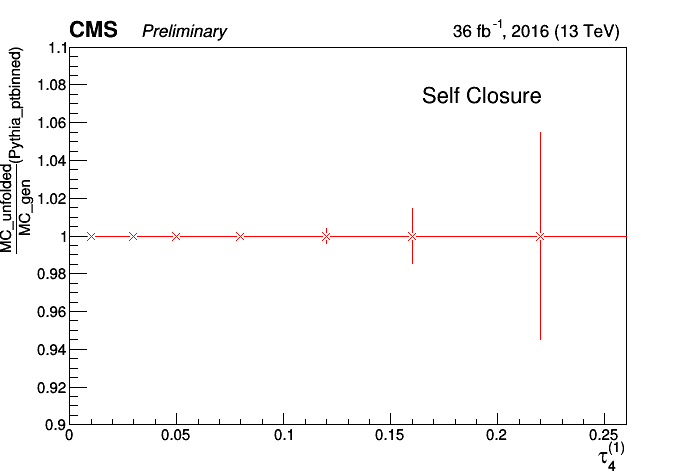

In [22]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.8
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV="36 fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c=rt.TCanvas()
ratio_unfoldings[i].SetTitle("")
ratio_unfoldings[i].GetYaxis().SetRangeUser(0.9,1.1)
ratio_unfoldings[i].GetXaxis().SetTitleSize(0.05)
ratio_unfoldings[i].GetXaxis().SetTitleOffset(0.8)
ratio_unfoldings[i].GetXaxis().SetTitle("#tau_{4}^{(1)}")
ratio_unfoldings[i].GetYaxis().SetTitle("#frac{MC_unfolded}{MC_gen}(Pythia_ptbinned)")
ratio_unfoldings[i].Draw()
CMS_lumi.CMS_lumi(c,4,0)
leg=rt.TLegend(.6,.7,.9,.9,'Self Closure')
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
c.Draw()

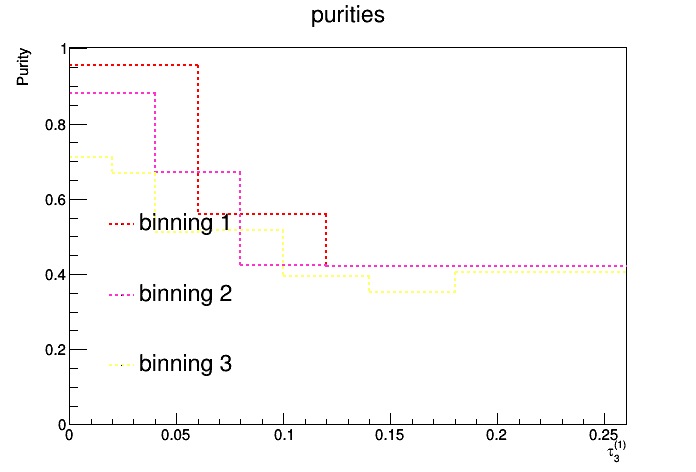

In [26]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

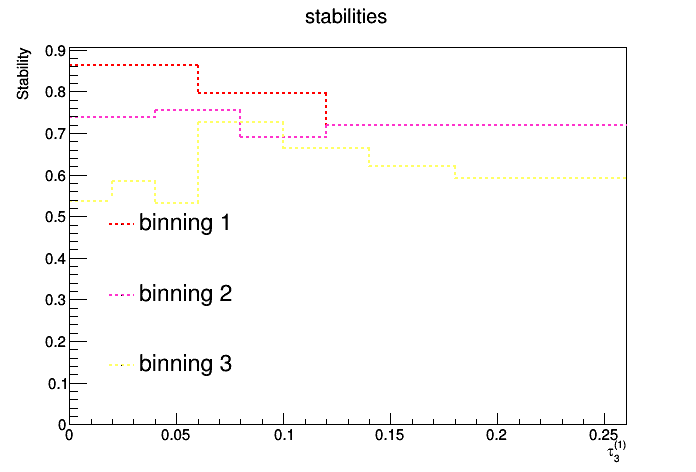

In [27]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response_tau_1_3_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_1_3_dijetSel.png has been created


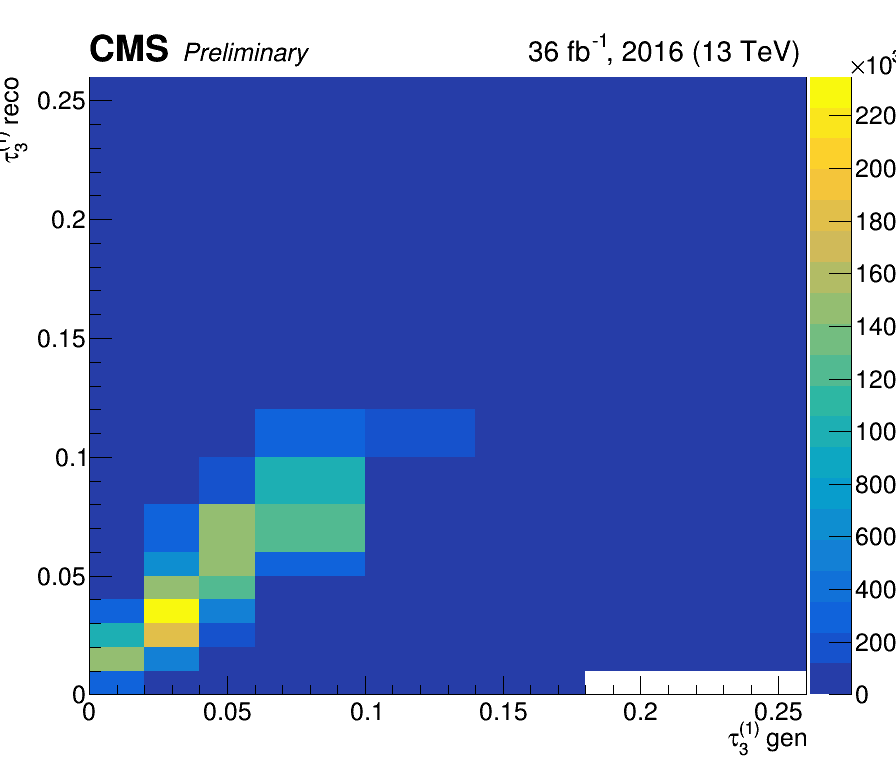

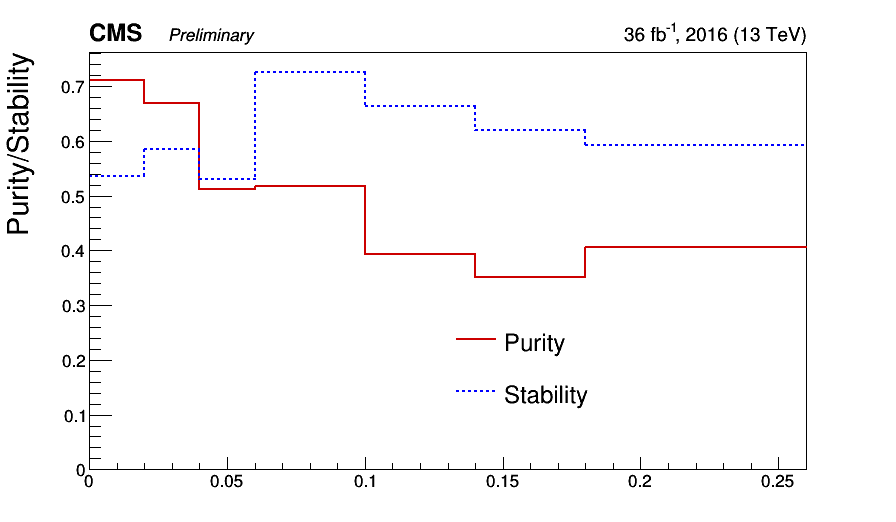

In [28]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV="36 fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.2,0.75,0.4)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_4^{(2)}$

In [29]:
reco='recoJet_tau_2_3_nom_dijetSel'
gen='genJet_tau_2_3_dijetSel'
response='respJet_tau_2_3_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


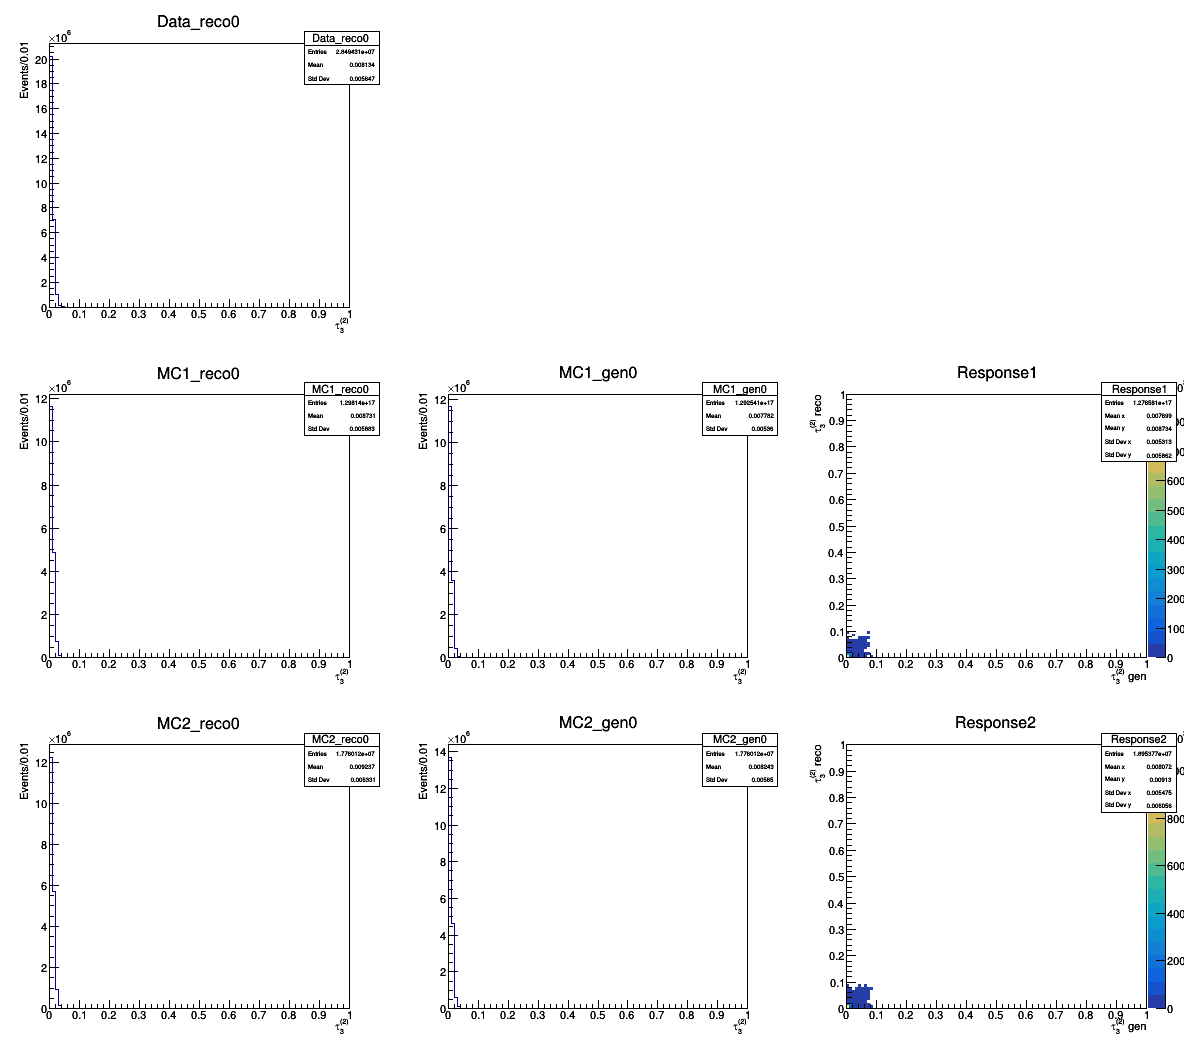

In [30]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(2)} gen;#tau_{3}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(2)} gen;#tau_{3}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [31]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 13696531.5254 12247217.6431
0.015 4640321.4984 5710643.02299
0.025 596308.162471 915547.317409
0.035 85618.8566249 136654.495622
0.045 15008.1339366 21962.0449505
0.055 2316.09627078 3808.71346717
0.065 415.69696462 455.137514113
0.075 27.8027662974 259.786816079
0.085 4.07354222723 3.68445527237
0.095 0.0 0.0
0.105 0.0 0.0
0.115 0.0 0.0
0.125 0.0 0.0
0.135 0.0 0.0
0.145 0.0 0.0
0.155 0.0 0.0
0.165 0.0 0.0
0.175 0.0 0.0
0.185 0.0 0.0
0.195 0.0 0.0
0.205 0.0 0.0
0.215 0.0 0.0
0.225 0.0 0.0
0.235 0.0 0.0
0.245 0.0 0.0
0.255 0.0 0.0
0.265 0.0 0.0
0.275 0.0 0.0
0.285 0.0 0.0
0.295 0.0 0.0
0.305 0.0 0.0
0.315 0.0 0.0
0.325 0.0 0.0
0.335 0.0 0.0
0.345 0.0 0.0
0.355 0.0 0.0
0.365 0.0 0.0
0.375 0.0 0.0
0.385 0.0 0.0
0.395 0.0 0.0
0.405 0.0 0.0
0.415 0.0 0.0
0.425 0.0 0.0
0.435 0.0 0.0
0.445 0.0 0.0
0.455 0.0 0.0
0.465 0.0 0.0
0.475 0.0 0.0
0.485 0.0 0.0
0.495 0.0 0.0
0.505 0.0 0.0
0.515 0.0 0.0
0.525 0.0 0.0
0.535 0.0 0.0
0.545 0.0 0.0
0.555 0.0 0.0
0.565 0.0 0.0
0.575 0.0 0.0
0.585 0.0 

In [32]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=2,start=0.,stop=0.04)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.09])))
reco_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.04)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.06,0.09])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=3,start=0.,stop=0.04)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.09])))
reco_bins1=np.array([x for x in np.linspace(num=5,start=0.,stop=0.04)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.06,0.09])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.04 0.09] 2
[0.   0.02 0.04 0.06 0.09] 4
0.0,0.04,0.09
0.0,0.02,0.04,0.06,0.09
[0.   0.02 0.04 0.09] 3
[0.   0.01 0.02 0.03 0.04 0.06 0.09] 6
0.0,0.02,0.04,0.09
0.0,0.01,0.02,0.03,0.04,0.06,0.09


In [33]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{3}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{3}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{3}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{3}^{(2)} gen;#tau_{3}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{3}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{3}^{(2)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{3}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.04 0.09]
for binning 2
[0.   0.02 0.04 0.09]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 4 input bins and 2 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #3 (xaxis:#tau_{3}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


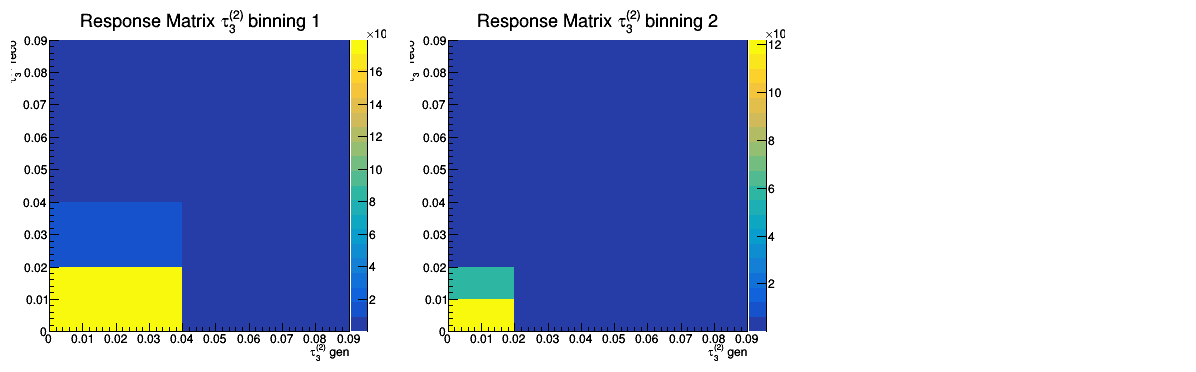

In [34]:
c=rt.TCanvas("","",0,0,1200,400)
c.Divide(3,1)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


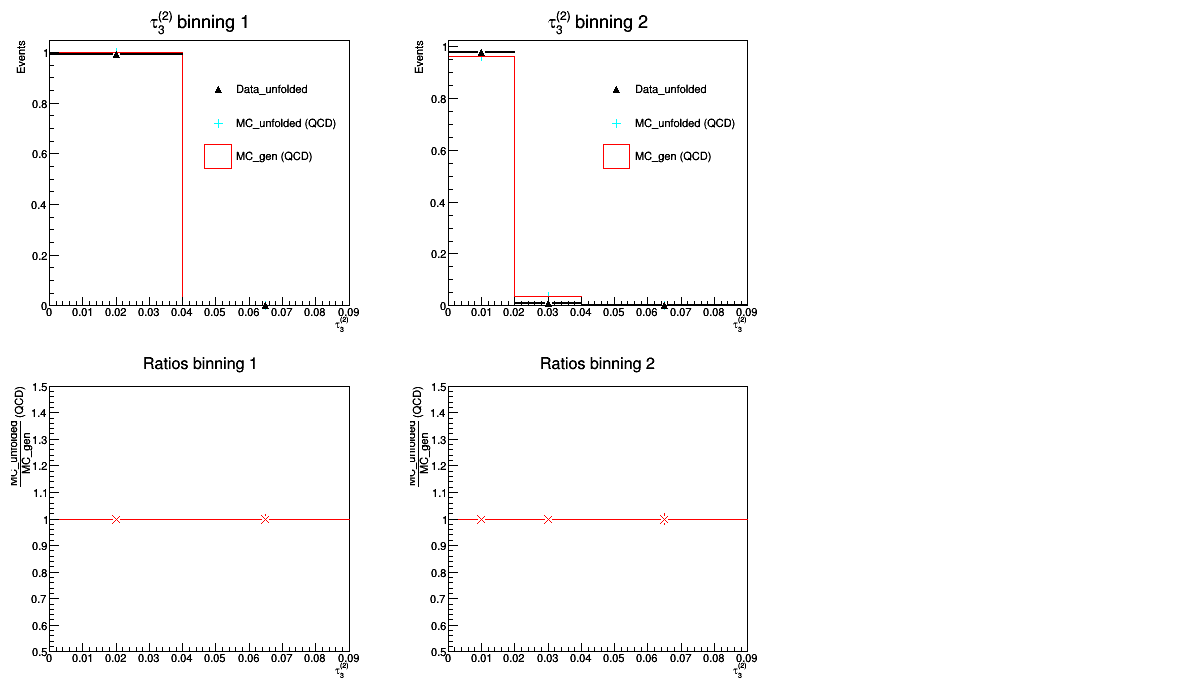

In [35]:
c=rt.TCanvas("","",0,0,1200,720)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{3}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(3,3+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-3].Draw()
c.Draw()

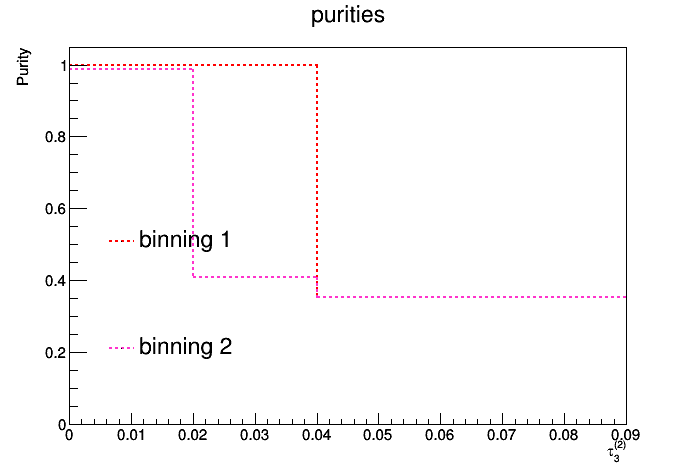

In [36]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{3}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

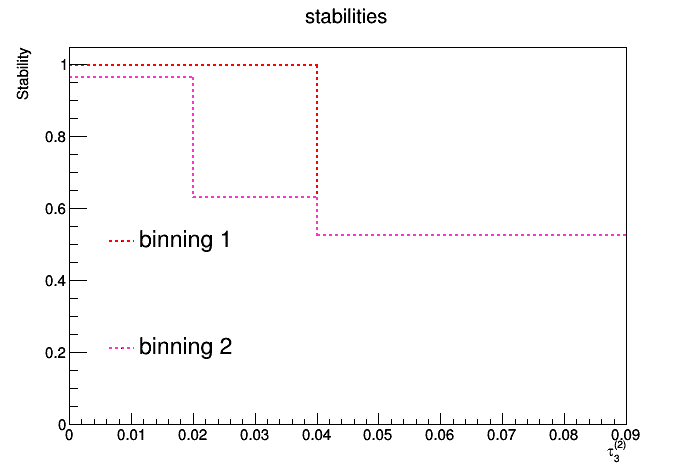

In [37]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{3}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response_tau_2_3_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_2_3_dijetSel.png has been created


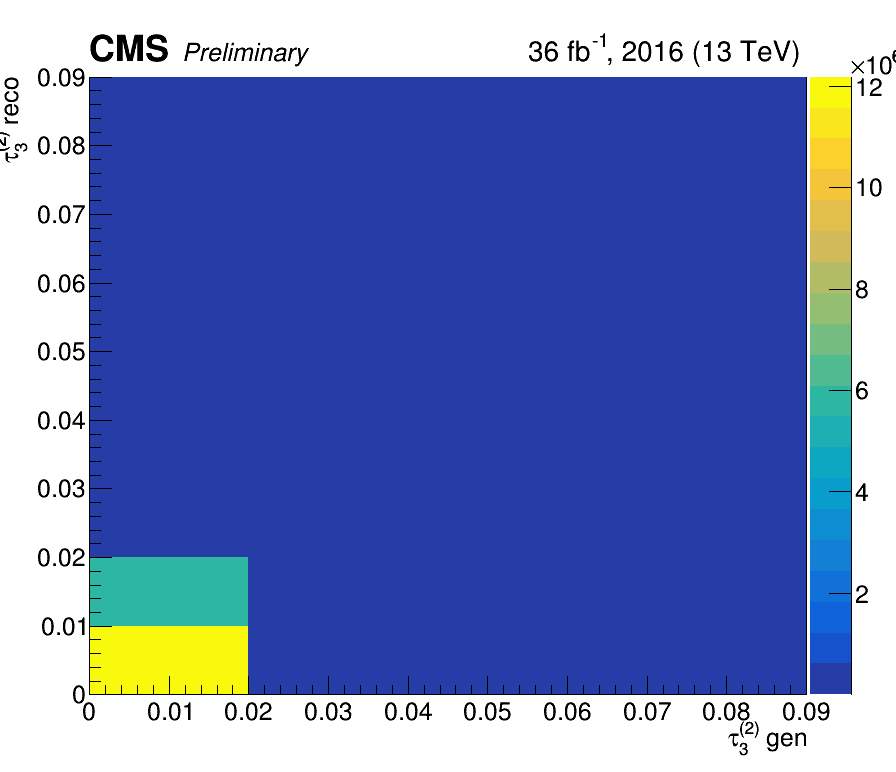

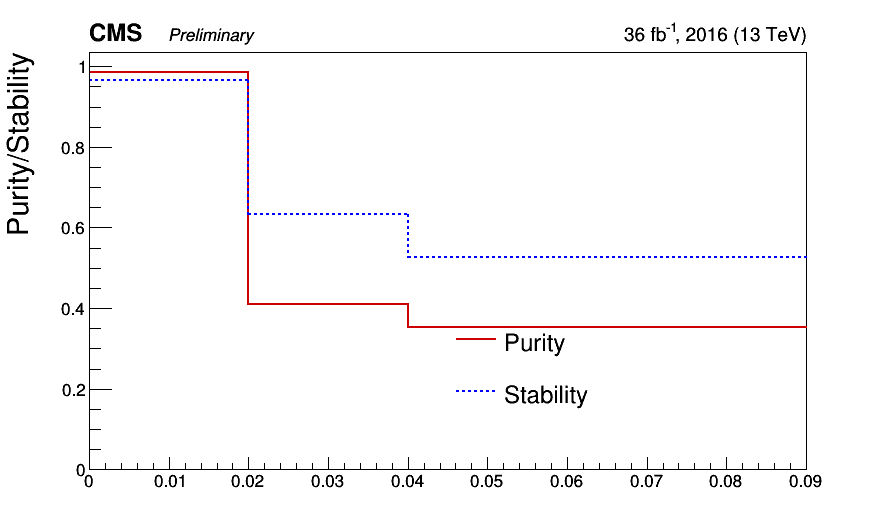

In [38]:
i=1
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV="36 fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.2,0.75,0.4)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability_OldSamples/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')